<a href="https://colab.research.google.com/github/yeric1789/CMSC320_Final_Project/blob/main/NoteBookFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Tutorial on Multi-label Classification**
By Mads Andersen and Noah Cubert

## Introduction

In this tutorial you will be learning how to utilize deep learning techniques to do multi-label classification on the NIH Chest X-ray dataset (https://www.kaggle.com/nih-chest-xrays/data). We expect you to have a basic understanding of Python, statistics, linear algebra, and simple data handling techniques. You are expected to have a working Jupyter Notebook and/or Python environment for running code. We will be using the PyTorch library for our deep learning models.

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.utils import resample
from scipy.stats import mannwhitneyu,shapiro

# Supress Warnings (For better readability of the notebook)
import warnings
warnings.filterwarnings('ignore')

In [218]:
sns.set_style("darkgrid")# Setting style for seaborn

After downloading the dataset you should make a folder call images and place all the images from our dataset into the folder. Here we are utilizing our own GPU to run our code. If you are using a different environment you may need to change the code to run on your own GPU or CPU. 

In [219]:
# check if google colab is exist
try:
    from google.colab import drive
    IN_COLAB = True
except Exception as e:
    IN_COLAB = False
    pass
# Load the data
if IN_COLAB:
    drive.mount('/content/drive')
else:
    print("Not in colab")

Not in colab


Now we want to load the labels for our data from the corresponding CSV file. Here we will sample 1500 images from the dataset and use 1000 of them for training and 500 for testing.

In [220]:
# Change path to your data path in google drive or local path 
path_use = "/content/drive/MyDrive/CMSC320-Intro_data_science/FinalProject/Data/Data_Entry_2017.csv" if IN_COLAB else 'D:/CMSC320_XRAY_CHEST_DATA/Data_Entry_2017.csv'
data = pd.read_csv(path_use)
data = data.iloc[:30000] # We use a subset 
# Randomly sample 1000 images
np.random.seed(0)
data = data.sample(n=1500, random_state=1)
data = data.reset_index(drop=True)

# Display the data
display(data)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00002787_000.png,No Finding,0,2787,31,F,PA,2048,2500,0.171,0.171,NaN
1,00003289_001.png,No Finding,1,3289,42,M,PA,2992,2991,0.143,0.143,NaN
2,00007728_002.png,No Finding,2,7728,27,M,AP,2500,2048,0.171,0.171,NaN
3,00002339_003.png,No Finding,3,2339,55,F,PA,2992,2991,0.143,0.143,NaN
4,00005640_000.png,Consolidation,0,5640,39,M,PA,2992,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,00001429_001.png,Fibrosis|Pleural_Thickening,1,1429,59,F,PA,2518,2589,0.143,0.143,NaN
1496,00007408_000.png,Atelectasis|Pneumonia,0,7408,49,F,PA,2048,2500,0.168,0.168,NaN
1497,00006217_003.png,No Finding,3,6217,22,M,AP,2500,2048,0.171,0.171,NaN
1498,00004517_005.png,Pneumothorax,5,4517,63,M,AP,2500,2048,0.171,0.171,NaN


### Data Exploration 
Each observation has an image and some more attributes attached to it, we will start by exploring some of the attributes first. 

In [221]:
data.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,0.0
mean,7.400000,3917.576000,47.699333,2512.304000,2365.513333,0.161769,0.161769,NaN
std,12.677716,2268.387832,19.165015,315.101413,368.109115,0.013507,0.013507,NaN
min,0.000000,1.000000,4.000000,1700.000000,1365.000000,0.115000,0.115000,NaN
25%,0.000000,1909.750000,36.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,3868.000000,49.000000,2500.000000,2048.000000,0.168000,0.168000,NaN
75%,8.000000,5913.250000,59.000000,2575.000000,2544.000000,0.171000,0.171000,NaN
max,107.000000,7810.000000,412.000000,3056.000000,3056.000000,0.194311,0.194311,NaN


One thing to note is that the 'Finding Labels' column shows all the labels for each image seperating multiple labels with a pipe (|). We will need to split these labels up and create a new column for each label.
We assign the 'Finding Labels' column updated such that each value is a list of labels that are applicable to that image. Now lets look at the frequency of each label within our dataset.

In [222]:
data['Finding Labels'] = data.apply(lambda x: x['Finding Labels'].split('|'),axis = 1)

# Count the different 
def overview_disease(data):
  overview = {}
  for findings in data['Finding Labels']:
    for j in findings:
      if j in overview.keys():
        overview[j] += 1
      else: 
        overview[j] = 1
  return overview
overview = overview_disease(data)
display(overview)


{'No Finding': 874,
 'Consolidation': 59,
 'Nodule': 71,
 'Pleural_Thickening': 46,
 'Pneumothorax': 58,
 'Effusion': 125,
 'Infiltration': 204,
 'Atelectasis': 136,
 'Cardiomegaly': 46,
 'Edema': 16,
 'Mass': 57,
 'Emphysema': 40,
 'Pneumonia': 18,
 'Fibrosis': 33,
 'Hernia': 5}

One thing to note about the frequency of our dataset is that the 'No Finding' label is the most common. This could cause some issues with our model as it will be more likely to predict 'No Finding' than any other label. We will take this into account when we train our model.

### Data Preprocessing
Now we can create a one-hot encoding dataframe of all the labels being assigned to each image. After that it can be concatenated with the originial data matrix.

In [223]:
dummies = pd.DataFrame(np.zeros((len(data), len(overview.keys())), dtype=np.int), columns=overview.keys())
for i,des in enumerate(data['Finding Labels']):
  dummies.loc[i][des] = 1

#Concat horizontally
data = pd.concat([data,dummies],axis=1)
display(data)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Infiltration,Atelectasis,Cardiomegaly,Edema,Mass,Emphysema,Pneumonia,Fibrosis,Hernia
0,00002787_000.png,[No Finding],0,2787,31,F,PA,2048,2500,0.171,...,0,0,0,0,0,0,0,0,0,0
1,00003289_001.png,[No Finding],1,3289,42,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00007728_002.png,[No Finding],2,7728,27,M,AP,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
3,00002339_003.png,[No Finding],3,2339,55,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
4,00005640_000.png,[Consolidation],0,5640,39,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,00001429_001.png,"[Fibrosis, Pleural_Thickening]",1,1429,59,F,PA,2518,2589,0.143,...,0,0,0,0,0,0,0,0,1,0
1496,00007408_000.png,"[Atelectasis, Pneumonia]",0,7408,49,F,PA,2048,2500,0.168,...,0,0,1,0,0,0,0,1,0,0
1497,00006217_003.png,[No Finding],3,6217,22,M,AP,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
1498,00004517_005.png,[Pneumothorax],5,4517,63,M,AP,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0


Now let's see which diseases are the most common, by plotting a histogram. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'No Finding'),
  Text(1, 0, 'Consolidation'),
  Text(2, 0, 'Nodule'),
  Text(3, 0, 'Pleural_Thickening'),
  Text(4, 0, 'Pneumothorax'),
  Text(5, 0, 'Effusion'),
  Text(6, 0, 'Infiltration'),
  Text(7, 0, 'Atelectasis'),
  Text(8, 0, 'Cardiomegaly'),
  Text(9, 0, 'Edema'),
  Text(10, 0, 'Mass'),
  Text(11, 0, 'Emphysema'),
  Text(12, 0, 'Pneumonia'),
  Text(13, 0, 'Fibrosis'),
  Text(14, 0, 'Hernia')])

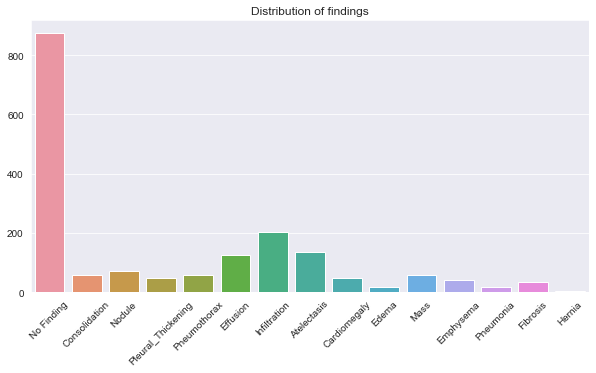

In [224]:
plt.rcParams["figure.figsize"] = (10,5)
x = list(overview.keys())
y = list(overview.values())
sns.barplot(x,y)
plt.title('Distribution of findings')
plt.xticks(rotation=45)

As can be seen there is large class imbalance. Lets explore how the age distribution looks, by plotting the histogram of the patient age. 

Text(0.5, 1.0, 'Patient age')

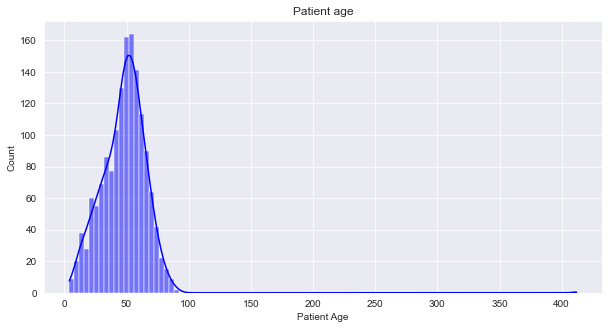

In [225]:
sns.histplot(data = data,x = 'Patient Age',color = 'b',kde=True)
plt.title("Patient age")

Looks like some 400 year old mummy is in our dataset, For our purposes this is not a problem, but if we were to use this dataset for medical purposes we would need to remove this outlier.


Lets us also look for any bias problems in our datasets.  One way we could search for bais is by differentiating between genders. This could be important since we want to know if the model might have some sort of bias against age or gender. 

Text(0.5, 1.0, 'Patient age')

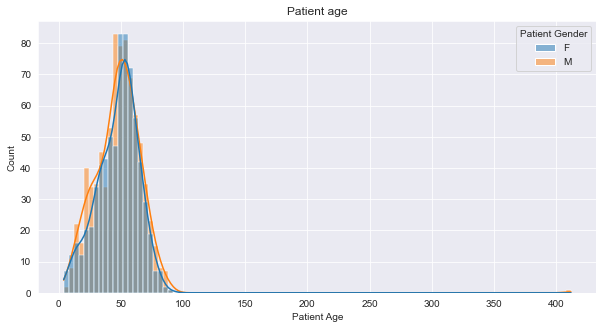

In [226]:
sns.histplot(data = data,x = 'Patient Age', hue = 'Patient Gender',kde=True)
plt.title("Patient age")

The distributions look extremely similar so the bias with regards to gender seems to be minimal.


## Testing for normality and difference in distributions
We can vizualize if gender has an influence on how frequent a lung diseases occur. One thing we can interpret from the plots is that it looks like the Male group has a higher variance. However from the plot it is quite hard to tell.

Another thing is that it looks like female genders might might follow a normal distribution somewhat however for the males we are hesitant to make any conclusions. In order to decide we will perform The Shapiro-Wilk test which has a null hypothesis (H0): that the data was drawn from a normal distribution, the result of this test will then determine if we choose to use a parametric or non-paramtric test between the two groups. 



In [227]:
gender_df = data.groupby('Patient Gender')
female, male = data[data['Patient Gender'] == 'F']['Patient Age'], data[data['Patient Gender'] == 'M']['Patient Age']
gender_df['Patient Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Patient Gender,,,,,,,,
F,704.0,47.53125,16.338059,4.0,36.0,50.0,59.0,91.0
M,796.0,47.84799,21.365010,4.0,35.0,49.0,59.0,412.0


In [228]:
shapiro(female).pvalue

3.514670368076622e-07

In [229]:
# The Shapiro-Wilk test
female_pval = shapiro(female).pvalue 
male_pval = shapiro(male).pvalue
string = f'p-value in test for normality \nFemale: {female_pval} \nMale: {male_pval}' 
print(string)

p-value in test for normality 
Female: 3.514670368076622e-07 
Male: 1.3914086940038445e-33


Since our p-values for both genders are less than 0.05 we can reject the null hypothesis and conclude that the data is not normally distributed. Because of this we will be using the The Mann-Whitney U test which is a non parametric test between distributions. The non-parametric is important here since it does not take any distribution into account. One reason we might not always want to use this is that it has lower statistical power, which means it will more often reject the null hypothesis when it should not. 

In [230]:
# mannwhitneyu test
diff_pvalue = mannwhitneyu(male,female).pvalue
if diff_pvalue > 0.05:
    print(f'We fail to reject the null hypothesis with significance 0.05 and with p-value: {diff_pvalue}')
else:
    print(f'We reject the null hypothesis with significance 0.05 and with p-value: {diff_pvalue}')

We fail to reject the null hypothesis with significance 0.05 and with p-value: 0.7203603799877727


So from the Mann-Whitney U test, we can derive that there is not a significant difference between Male and Female ages for the diseases we are looking at. Do note that all of this has been computed on a subset of the real data-set and thus may not be representative for the entire data-set. 

## Correlation between variables

Now we can plot the correlation matrix, to check if any of the findings often occur together. Note that we have temporarily dropped *'No Finding'* label since it will never occur together with any of the other variables.

Text(0.5, 1.0, 'Correlation matrix of findings')

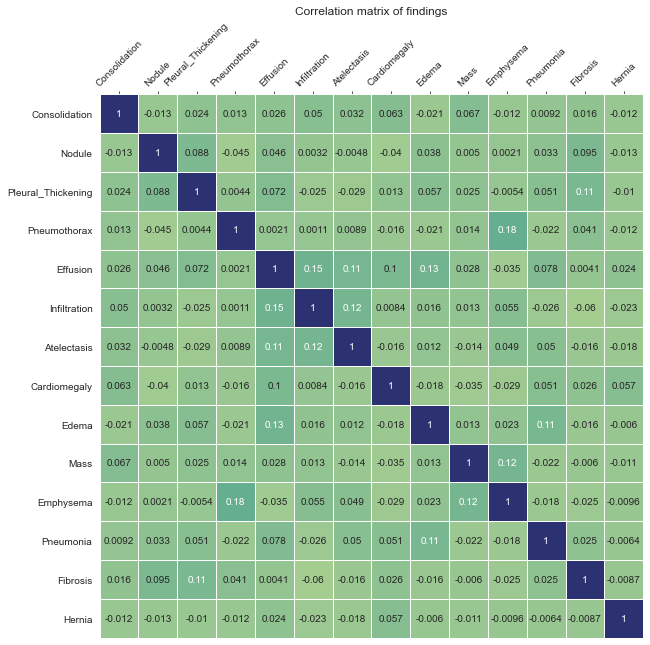

In [231]:
plt.rcParams["figure.figsize"] = (15,10)
df = dummies.drop(columns = 'No Finding').corr()
ax = sns.heatmap(df,annot = True,cmap="crest",square=True, linewidths=.5,cbar=False)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=45)
plt.title('Correlation matrix of findings')

None of our datapoints seem to be highly correlated with each other. This is good since it means that our model will not be biased towards any of the labels.

## Image Show-casing

Now we can look at some of the images in our dataset. We will be using the matplotlib library to display the images.

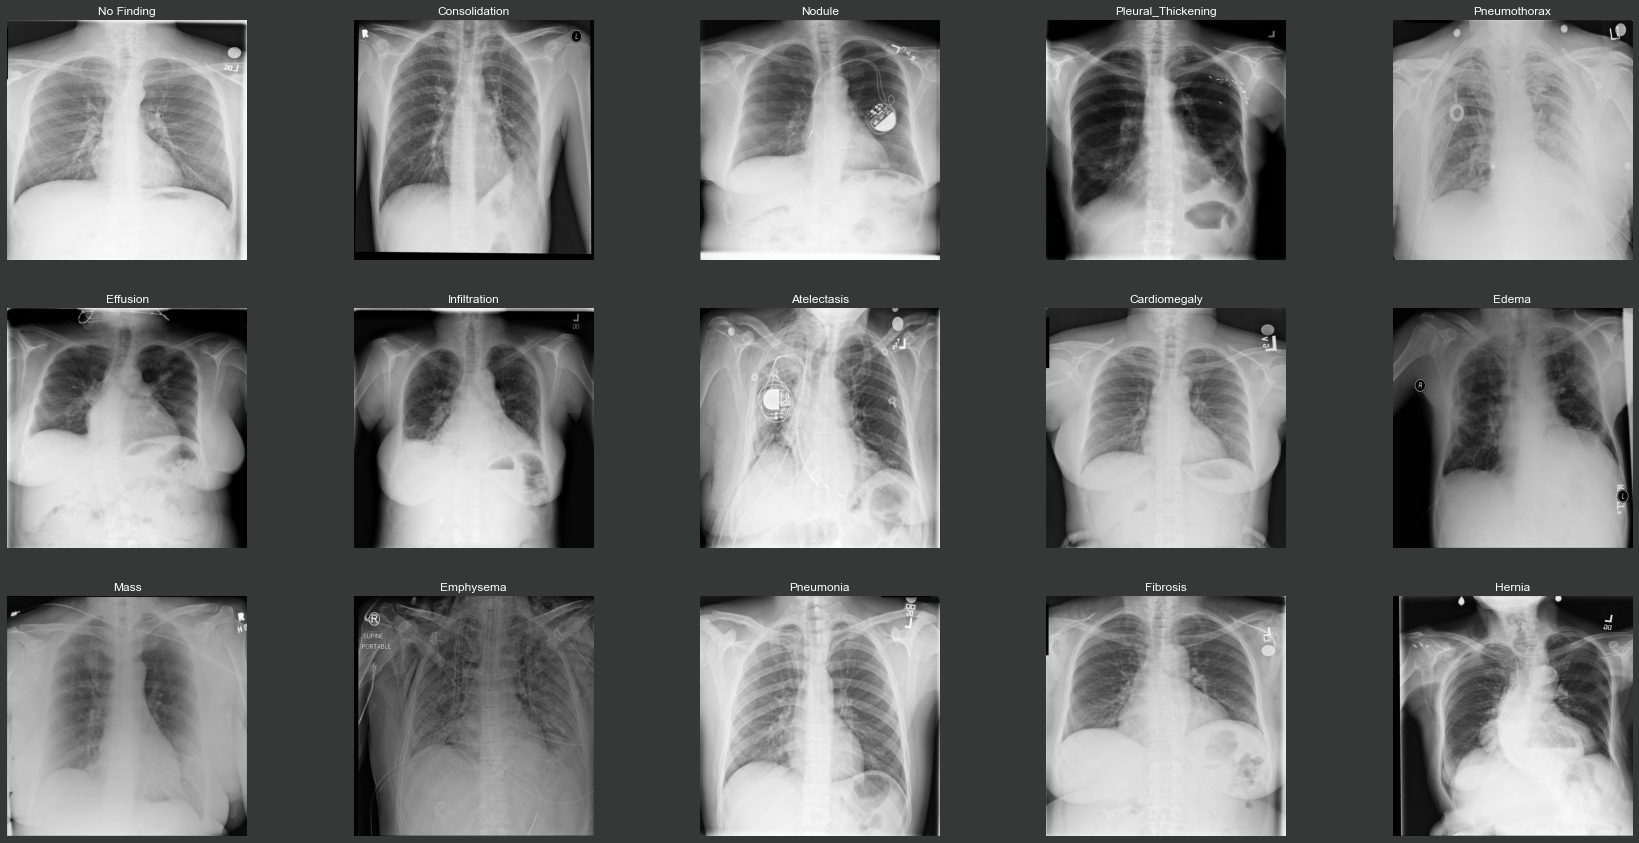

In [232]:
# Plot the images
ht = 3
wd = 5
plt.rcParams["figure.figsize"] = (2*ht*wd,ht*wd)
plt.rcParams["axes.grid"] = False
# Change path to your data path in google drive or local path
imag_dir = '/content/drive/MyDrive/CMSC320-Intro_data_science/FinalProject/Data/images/' if IN_COLAB else 'D:/CMSC320_XRAY_CHEST_DATA/images/'
# 15 different labels

fig, ax = plt.subplots(ht,wd)
# Gray background
fig.patch.set_facecolor('xkcd:dark grey')
n_img = 0


# Get 
unique_labels = [str(i) for i in data.columns[12:]]
for i in range(ht):
    for j in range(wd):
        # Pop unique label to use
        label = unique_labels.pop(0)
        # Get sample one image from the set of images with the label
        sample = data[data[label] == 1].sample(n=1)
        path_img = imag_dir + sample.iloc[0]['Image Index']
        img = plt.imread(path_img)
        ax[i,j].imshow(img, cmap = 'gray')
        ax[i,j].set_title(label, color = 'white')
        # set color 
        ax[i,j].set_axis_off()
        n_img += 1

### Plotting Histogram of Pixel Intensities

Text(0.5, 1.0, 'Histogram of pixel intensity')

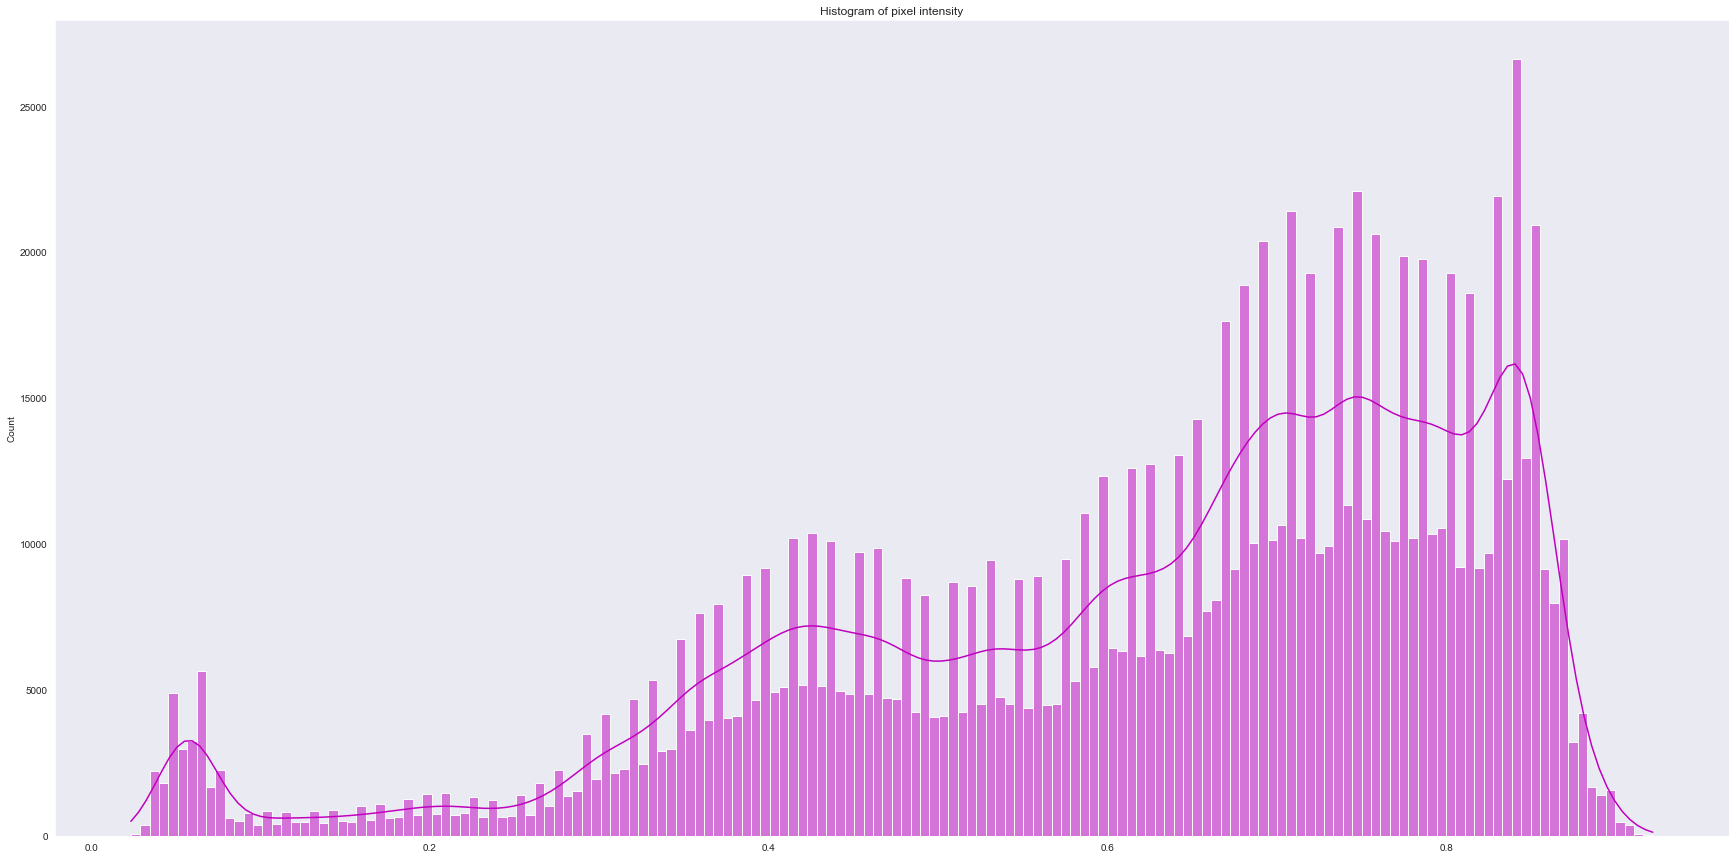

In [233]:
path_img =imag_dir+data.iloc[0]['Image Index']
img = plt.imread(path_img)
pixels = img.reshape(-1)
sns.histplot(pixels,color = 'm',kde=True)
plt.title("Histogram of pixel intensity")

# Predicting the label from images. 

First we have to do some imports, also we will be using torchmetrics, since it does not exist in Colab we have to use `!pip install torchmetrics` to install it

In [234]:
!pip install torchmetrics torchviz

failed to create process.


In [235]:
#Torch imports 
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.models import inception_v3,resnext50_32x4d,vgg11_bn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch import nn
import torch.functional as F

from PIL import Image
import glob
import os
from skimage import io, transform
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split


#Requires pip install 
from torchmetrics.classification import Accuracy, BinaryAccuracy
from torchviz import make_dot

# weighted random sampler
from torch.utils.data.sampler import WeightedRandomSampler


In [236]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Cross validation 
First let us make sure that we make a trainning,validation and test set. The training and validation sets will be used during training. We will specifically train on train-set, and then to figure out when to stop training we run the model on our validation set for each epoch. Once we have stopped the training, we will do a final run on our test-set in order to asses, how well we can expect to generalize beyond the training data. We will also be using the results from that test set, to run our statistics on, so that we can end up with a final verdict on how well we did. 

Since we have random sampled from the image data-set, we don't need to worry about randomizing the splits. One thing we would like to point out is the stratification part. Ussually when working with classification one would stratify the splits, meaning that there would be and equal amount of each label class in the split. However we are working with multilabel classification, so stratification would almost be a torturial on it's own. We will accept this shortcomming for the sake of keeping complexity down in this torturial. 


In [237]:
train_df = data[:1000]
val_df = data[1250:]
test_df = data[1000:1250]

overview = overview_disease(train_df)
nre = np.array(list(overview.values()))/sum(overview.values())

# Convert to tensor
nre = torch.from_numpy(nre).float()

#train_df, test_df = train_test_split(data,test_size=0.15, random_state=42)

## Data handling with Pytorch

In order to work with pytorch and the image data, we have to create a costoum data-set. This is basically just a class, where you specify the __len__() and __getitem__() methods. Especially __getitem__() is important in this case, since we don't wan't to load all of the images into the ram at once. We are working with a big data-set and we can easily end up using all of the ram if we are not smart about how we do the loading of the data. 

The way we construct the data-set class is that each time the __getitem__() class is called it loads the image from the directory. This means that we only take images into the ram when we actually need them. 

Another thing we adress in this class is the construction of labels and transformations we apply to the images. We will be explaining two forms of classificatin binary and multi-label. The first method is quite a lot simpler than the second. 

### Binary
The way we can convert the problem to a binary problem is simply by only predicting if the image contains a finding or no finding, but not which specific finding that is being considered. 

### Multi-label 
Here we would actually try to predict which exact label to assign to given image.

The way this can be handled with pytorch is simply to create a binary variable indicating if we want to work with the binary data or the multi-label data. Notice how there is different if statements in the __getitem__() method. This allows us to only implement one class, instead of having to redefine the class. 

In [238]:
class LungDataSet(Dataset):
  
  def __init__(self,df,root_dir,input_size,transform = None, binary = True, cuda_device = None):
    self.df = df 
    self.root_dir = root_dir
    self.transform = transform
    self.input_size = input_size
    self.binary = binary
    self.cuda_device = cuda_device

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
            idx = idx.tolist()
    
    img_name = self.df.iloc[idx,0]
    path = os.path.join(self.root_dir,img_name)
    #print(path)

    image = io.imread(path)
    avg = np.mean(image)
    std = np.std(image)
    image = (image - avg)/std
    
    if len(image.shape) > 2: # For some reason some of the images have copied slices of them self so they are 3d 
      image = image[:,:,0]
      
    image = torch.tensor([transform.resize(image, self.input_size) for i in range(3)]) # This is just me trying stuff 
    
    if self.binary:
      labels = self.df.iloc[idx,15] #12: if we use all labels
      labels = torch.tensor([1,0]) if labels.item() == 0 else torch.tensor([0,1]) # Notice how 0 in no finding means there is a finding
    else: 
      labels = self.df.iloc[idx,12:]
      labels = labels.to_list()
    
    labels = torch.tensor(labels).to(float)

    if self.transform:
      image  = self.transform(image)
    
    sample = {'image': image, 'labels': labels}
    #print("Type of sample['image']: ", sample['image'].shape)


    return sample 

### Transforms of images 
As we are using the ResNet architecture, we are risking overfitting the network to the images, in order to combat this we will be using transformations. The ones we will be using are random horizontal flips and random vertical flips. These transformations are basically just flipping the images in random directions, this is in the hope that the network will learn the representation of the actual illness and not be biased towards the direction of the image it is seeing. Furthermore 

In [239]:
test_tform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

IMG_SHAPE = (299,299)
train_tform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.ToTensor()
                                ])
dir = '/content/drive/MyDrive/CMSC320-Intro_data_science/FinalProject/Data/images/' if IN_COLAB else 'D:/CMSC320_XRAY_CHEST_DATA/images/'
train_set = LungDataSet(df = train_df,
                        root_dir = dir,
                        input_size = IMG_SHAPE,
                        transform = train_tform,
                        binary = False,
                        cuda_device=device)

val_set = LungDataSet(df = test_df,
                       root_dir = dir,
                       input_size = IMG_SHAPE,
                       transform = test_tform, #We will be using the same transform
                       binary = False,
                       cuda_device=device)

test_set = LungDataSet(df = test_df,
                       root_dir = dir,
                       input_size = IMG_SHAPE,
                       transform = test_tform,
                       binary = False,
                       cuda_device=device)

## Visualize the data we will be training on 

0 torch.Size([3, 299, 299]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
1 torch.Size([3, 299, 299]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
2 torch.Size([3, 299, 299]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
3 torch.Size([3, 299, 299]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)


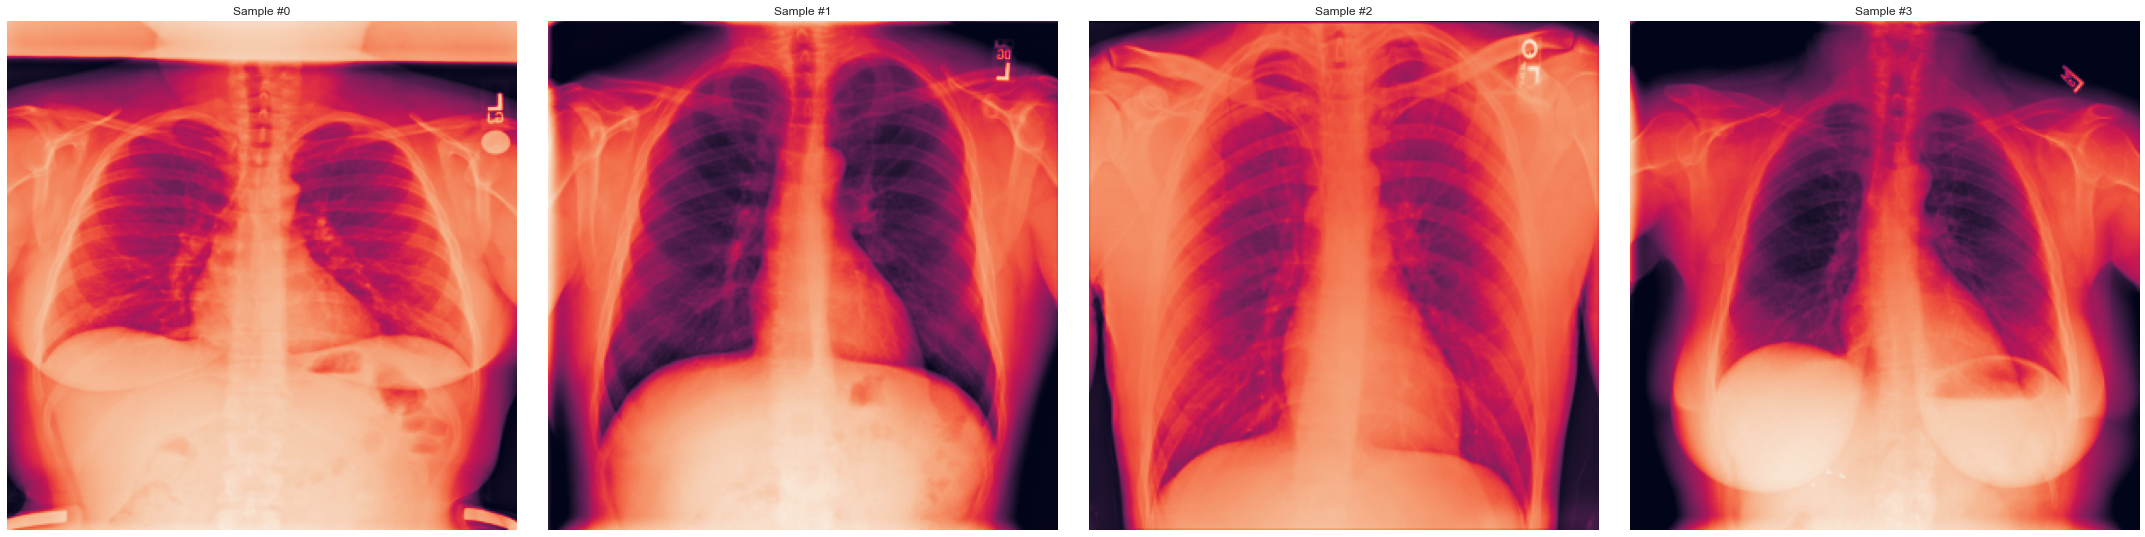

In [240]:
def visualize(data):
    fig = plt.figure()
    for i in range(len(data)):
        sample = data[i]

        print(i, sample['image'].shape, sample['labels'])

        ax = plt.subplot(1, 4, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')
        plt.imshow(sample['image'][0,:,:])

        if i == 3:
            plt.show()
            break

if device == "cuda":
    train_set2 = LungDataSet(df = train_df,root_dir = dir,input_size = IMG_SHAPE,binary =False, cuda_device=None)
    test_set2 = LungDataSet(df = test_df,root_dir = dir,input_size = IMG_SHAPE, cuda_device=None)
    visualize(train_set2)
else:
    visualize(train_set)

In [241]:
#Train Loader 
train_dataloader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)

#Val Loader 
val_dataloader = DataLoader(val_set, batch_size=4, shuffle=True, num_workers=0)

#Test Loader
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)

## Defining the models

We will be using Resnet or VGG as the backbone for our image classifier, what this means is that we are using the pretrained weights for the architecture Resnet, and then we modify the last layer to be a linear classifier which will then output the desired number of output neurons we want. 

In the implementation below notice, how we again make sure that we can take a different number of classes, this is again in order to do both binary classification and multi-label classification. 

The way we use the pretrained models are by simply writing a new class, which will call the pretrained model with it's weights (`resnet = resnext50_32x4d(pretrained=True)`). After this we ensure that every parameter in the network has the `.requires_grad` field set to true, this means that we can optimize all of the paramters in the network. In theory the transfer learning approach means that we will use the pretrained network as an encoder, however as will be eveident later in this torturial there is some convergence probalems, meaning that we want to simply initialize our network on these parameters. The classifier we are using will be a linear classifier, meaning it is simply a vector for each class multiplied with the feature maps in the last layer. 

In [242]:
class DenseNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = True #This was set to False 
        
        resnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.classifier.in_features, out_features=n_classes)
        )
        self.n_classes = n_classes
        self.base_model = resnet
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax()
             
    def forward(self, x):
        if self.n_classes > 2:
          return self.sigm(self.base_model(x))
        else: 
          return self.softmax(self.base_model(x))

model_DN = DenseNet(n_classes=15)
model_DN.to(device)

Using cache found in C:\Users\noahc/.cache\torch\hub\pytorch_vision_v0.10.0


DenseNet(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum

Define the actual objects. 

## Vizualising the model architecture 
It can be hard to get an overview of what the model actually is. In order to help better comunicate the model, we will be using a tool calle torchviz which will construct a graph showcasing the neural network. We will be showcasing the VGG net in this case, this will help you realize the scale of these models, and how many paramters there actually is in a network like this one. 

In [243]:
# from torchviz import make_dot
# x = torch.randn(1,3,320,320).to(device)
# model_DN.eval()
# y = model_DN(x)

# make_dot(y.mean(), params=dict(model_DN.named_parameters()))




### Loss, optimizer and scheduler 
Define loss function and the optimizer, we will be using the Adam optimizer. The loss function will be binary cross-entropy. Another thing we will define is a scheduler, which allows us to addapt the learning rate of the optimizer for each epoch. We do this because we may be interested in having a higher lr in the beginning of the training, and then as we progress we want to take smaller and smaller steps in order to reduce the chance of overshooting the minima

In [244]:
# loss_fn = BCEWithLogitsLoss()
loss_fn = nn.BCELoss(weight=torch.tensor(nre).to(device))

optimizer_DN = torch.optim.Adam(model_DN.parameters(), lr=1e-3)
scheduler_DN = StepLR(optimizer_DN, step_size=1, gamma=0.2)


## Model training
Training loop for the model. In this cell we will be training the model. This is doen by first calling `model.train()` which basically sets the model in training mode. After this is done, we want to make a prediction for each of the batches *(we are using stochastic gradient descent)* and then based of that predictin find the gradient so that we can optimize our network. The way we find the gradient is by calling `loss.backward()` this runs the back probagation algorithm. 

In [245]:
def train(dataloader, model, loss_fn, optimizer, accuracy):
    size = len(dataloader.dataset)
    model.train()
    loss_tracker = []
    for batch, point in tqdm(enumerate(dataloader)):
        X = point['image']
        y = point['labels']

        X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_tracker.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Training Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            #print(f'pred:{pred}\nGT:{y}')
            acc = accuracy(pred,y)
            # From tensor to numpy
            acc2 = acc
            acc2 = acc2.cpu().detach().numpy()
            print(f'Training Accuracy:{acc2}')
        
    return np.mean(loss_tracker)

## Model testing 
The function belowe is testing our model, on the validation set. This is an important part in that it gives us a reality check into if our model is overfitted or actually will generelize beyond our training data. When working with pytorch there is a few things to consider in this step:

Wrap code in: `with torch.no_grad():` this tells pytorch that we will not be 

1.   Wrap code in: `with torch.no_grad():` this tells pytorch that we will not be using the gradients and it will speed up the iteration.
2.   Set model to `model.eval()` this sets the model in evaluation mode, meaning we can parse none badtched data to it as an example. 

Other than that we will simply do the forward pass, and then collect the valuable information such as, predictions and loss. 


In [246]:
def validation(dataloader, model, loss_fn, accuracy):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    predictions = []
    #f = nn.Softmax(dim = 1)
    i = 0
    avg_acc_arr = []
    with torch.no_grad():
        for point in dataloader:
            X = point['image'].to(torch.float32)
            y = point['labels'].to(torch.float32)

            X, y = X.to(device,dtype=torch.float), y.to(device,dtype=torch.float)
            pred = model(X)
            predictions.append((pred,y))
            #return pred, y 

            test_loss += loss_fn(pred, y).item()
            
            correct += ((pred > 0.5 - y).sum().item()) == 0
            acc = accuracy(pred,y)
            
            if i % 200 == 0:
    
                print(f'Validation cummulative loss: {test_loss} \n Prediction:{pred.detach().cpu().numpy()}')
                print(f'Validation Accuracy: {acc}')
            i += 1
    test_loss /= num_batches
    correct /= size

    # Make mappping of predictions and labels
    # From tensor to numpy
    predt = list([pred.detach().cpu().numpy() for pred, y in predictions])
    mapping = {train_df.columns[i]: predt[i] for i in range(len(train_df.columns))}
    return np.mean(test_loss), mapping

## Binary classification vs Multi-label classification
Now that we have the two functions defined we are ready to actually do the training, by calling the functions in another loop. Each iteration of a training loop, is known as an epoch. For each epoch we train we also want to validate if our model is overfitting or not, therefore we call the test function (we should prob rename). 

Notice that we in this loop also calls the `scheduler.step()` which tells the scheduler that it should decrease the learning rate by the ammount specified earlier as the gamma value. Further more we also incorporate an early stopping, meaning that if the current version of the model does not have improved test accuracy over the last two epochs we break it. The reason for this is that an increasing test performance is signaling that our model may be overfitting to the training data. 

In [247]:
epochs = 15

def run_training(epochs, binary = False ):
    train_loss = []
    test_loss = []
    predictions = []
    
    if not binary:
      accuracy_fn = Accuracy('multilabel', num_labels=15, average=None).to(device)
      for t in tqdm(range(epochs)):
      # Train
        epoch_train_loss = train(train_dataloader, model_DN, loss_fn, optimizer_DN, accuracy_fn)
        train_loss.append(epoch_train_loss)
        epoch_test_loss, epoch_predictions = validation(val_dataloader, model_DN, loss_fn, accuracy_fn)
        test_loss.append(epoch_test_loss)
        predictions.append(epoch_predictions)
        scheduler_DN.step()
        print(f"Epoch {t+1} Train Loss: {epoch_train_loss} Test Loss: {epoch_test_loss}")
    else:
      accuracy_fn = Accuracy('binary', num_labels=1, average=None).to(device)

      train_set_bn = LungDataSet(df = train_df,root_dir = dir,input_size = IMG_SHAPE,binary =True, cuda_device=None)
      val_set_bn = LungDataSet(df = val_df,root_dir = dir,input_size = IMG_SHAPE,binary =True, cuda_device=None)

      train_dataloader_bn = DataLoader(train_set_bn, batch_size=8, shuffle=True)
      test_dataloader_bn = DataLoader(val_set_bn, batch_size=4, shuffle=True)

      model_DN_bn = DenseNet(n_classes=2)
      model_DN_bn.to(device)
      
      for t in tqdm(range(epochs)):
        # Train
        epoch_train_loss = train(train_dataloader_bn, model_DN_bn, loss_fn, optimizer_DN, accuracy_fn)
        train_loss.append(epoch_train_loss)

        epoch_test_loss, epoch_predictions= validation(test_dataloader_bn, model_DN_bn, loss_fn, accuracy_fn)
        test_loss.append(epoch_test_loss)
        predictions.append(epoch_predictions)

        scheduler_DN.step()
        print(f"Epoch {t+1} Train Loss: {epoch_train_loss} Test Loss: {epoch_test_loss}")
      


    
    return train_loss, test_loss, predictions

run_training(epochs, binary = False)

# Save model
torch.save(model_DN.state_dict(), 'model_DN.pt')

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Training Loss: 0.046402  [    0/ 1000]
Training Accuracy:[0.5   0.625 0.75  0.375 0.625 0.    1.    0.125 0.    0.25  0.75  0.75
 0.25  0.5   1.   ]


KeyboardInterrupt: 

The step above is where you as the programmer are going to do so adjustments yourself. The overall thing to look for, is a generel decreasing training loss, but also that the test loss is decreasing along with it. If you start to see a test loss that is increasing while training loss is decreasing then abort mission, because you are overfitting. 

Another thing thing when training an NN, is that we have to set the hyper-parameters our self. One could use gridsearch or baysian optimization to find these paramters however these will require you to fully train a network multiple times, and in our case when we are using ResNet as the backbone it has around 11 million parameters. Therefore if you see the training loss bouncing around but not really decreasing in generel try to lower the learning rate. Youd could also try to adjust the batch size, since we are using stochastic gradient descent. The batchsize can be thought of as the amount of samples we use to estimate our gradient before stepping in the negative direction of it. 

## Testing 
Now we want to run the model on the completely new testing data. 

In [ ]:
model_DN.eval()
model_DN.to(device)
acc = Accuracy('multilabel', num_labels=15, average=None).to(device)
predictions = torch.zeros(len(test_dataloader),15)
labels = torch.zeros(len(test_dataloader),15)

for idx,point in tqdm(enumerate(test_dataloader)):
  with torch.no_grad():
    X,y = point['image'].to(device),point['labels'].to(device)
    pred = model_DN(X)
    predictions[idx,:] = pred
    labels[idx,:] = y

0it [00:00, ?it/s]

In [ ]:
y.shape

torch.Size([1, 15])

In [ ]:
labels.shape

torch.Size([250, 1])

In [ ]:
acc(predictions,)